# General import functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
import anndata

sc.logging.print_versions()

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.5.1 anndata==0.6.22 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
pwd

'/home/angela/sapiens/tabula-sapiens/analysis-scripts/pilot1/pilot1-analysis-draft'

# Load the data

## Blood re-run


### 

In [10]:
import os
pilot_runs1 = [x[1] for x in os.walk('/mnt/ibm_lg/angela/sapiens/TSP1_blood_1_redo')][0]
pilot_runs1

['TSP1_blood_1_redo_4',
 'TSP1_blood_1_redo_3',
 'TSP1_blood_1_redo_2',
 'TSP1_blood_1_redo_1']

In [11]:
import os
pilot_runs2 = [x[1] for x in os.walk('/mnt/ibm_lg/angela/sapiens/TSP1_blood_2_redo')][0]
pilot_runs2

['TSP1_blood_2_redo_1',
 'TSP1_blood_2_redo_3',
 'TSP1_blood_2_redo_4',
 'TSP1_blood_2_redo_2']

In [104]:
adata_blood1redoconcat = sc.read_10x_mtx('/mnt/ibm_lg/angela/sapiens/TSP1_blood_1_redo_concat/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
#     var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)  
adata_blood1redoconcat.obs['sample'] = 'blood1_redo_concat'

adata_blood2redoconcat = sc.read_10x_mtx('/mnt/ibm_lg/angela/sapiens/TSP1_blood_2_redo_concat/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
#     var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)  
adata_blood2redoconcat.obs['sample'] = 'blood2_redo_concat'

In [105]:
adata = adata_blood1redoconcat.concatenate(adata_blood2redoconcat)
adata

AnnData object with n_obs × n_vars = 13589760 × 58870 
    obs: 'batch', 'sample'
    var: 'gene_ids', 'feature_types'

In [106]:
adata.write('/mnt/ibm_lg/angela/sapiens/TSP1-blood-rerun-concat-raw.h5ad')

... storing 'sample' as categorical
... storing 'feature_types' as categorical


In [102]:
adata_blood1redoconcat.obs.index

Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCAT-1', 'AAACCCAAGAAACCCA-1',
       'AAACCCAAGAAACCCG-1', 'AAACCCAAGAAACCTG-1', 'AAACCCAAGAAACGAA-1',
       'AAACCCAAGAAACGTC-1', 'AAACCCAAGAAACTAC-1', 'AAACCCAAGAAACTCA-1',
       'AAACCCAAGAAACTGC-1',
       ...
       'TTTGTTGTCTTTCTTC-1', 'TTTGTTGTCTTTGAGA-1', 'TTTGTTGTCTTTGATC-1',
       'TTTGTTGTCTTTGCAT-1', 'TTTGTTGTCTTTGCGC-1', 'TTTGTTGTCTTTGCTA-1',
       'TTTGTTGTCTTTGCTG-1', 'TTTGTTGTCTTTGGAG-1', 'TTTGTTGTCTTTGGCT-1',
       'TTTGTTGTCTTTGTCG-1'],
      dtype='object', length=6794880)

In [103]:
adata_blood1redoconcat.obs.index = ['blood1_redo_concat_'+i for i in adata_blood1redoconcat.obs.index]
# ['blood1redoconcat_']+list(adata_blood1redoconcat.obs.index)

In [12]:
adataaux = []
for r in pilot_runs1:
    print(r)
    path = '/mnt/ibm_lg/angela/sapiens/TSP1_blood_1_redo/' + r + '/raw_feature_bc_matrix/'
    foo = sc.read(path + 'matrix.mtx.gz', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'features.tsv.gz', dtype=str)[:, 1]
    foo.obs_names = r+'_'+np.genfromtxt(path + 'barcodes.tsv.gz', dtype=str)
    foo.obs['tissue'] = r.split('_')[1]
    foo.obs['10X_plate'] = r.split('_')[2]
    
    adataaux.append(foo)
    
for r in pilot_runs2:
    print(r)
    path = '/mnt/ibm_lg/angela/sapiens/TSP1_blood_2_redo/' + r + '/raw_feature_bc_matrix/'
    foo = sc.read(path + 'matrix.mtx.gz', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'features.tsv.gz', dtype=str)[:, 1]
    foo.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz', dtype=str)
    foo.obs['tissue'] = r.split('_')[1]
    foo.obs['10X_plate'] = r.split('_')[2]
    
    adataaux.append(foo)


first = adataaux.pop()
adata = first.concatenate(adataaux)
adata.obs['method'] = 'droplet'
adata.obs['sex'] = 'female'
adata.obs['subjectid'] = 'pilot'

adata.obs.head()

TSP1_blood_1_redo_4
TSP1_blood_1_redo_3
TSP1_blood_1_redo_2
TSP1_blood_1_redo_1
TSP1_blood_2_redo_1
TSP1_blood_2_redo_3
TSP1_blood_2_redo_4
TSP1_blood_2_redo_2


Making variable names unique for controlled concatenation.


,10X_plate,batch,tissue,method,sex,subjectid
AAACCCAAGAAACACT-1-0,2,0,blood,droplet,female,pilot
AAACCCAAGAAACCAT-1-0,2,0,blood,droplet,female,pilot
AAACCCAAGAAACCCA-1-0,2,0,blood,droplet,female,pilot
AAACCCAAGAAACCCG-1-0,2,0,blood,droplet,female,pilot
AAACCCAAGAAACCTG-1-0,2,0,blood,droplet,female,pilot


In [13]:
adata

AnnData object with n_obs × n_vars = 54359040 × 58870 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid'

save the very raw object...

In [14]:
adata.write('/mnt/ibm_lg/angela/sapiens/TSP1-blood-rerun-raw.h5ad')

... storing '10X_plate' as categorical
... storing 'tissue' as categorical
... storing 'method' as categorical
... storing 'sex' as categorical
... storing 'subjectid' as categorical


## Blood realignment


In [87]:
import os
tsp1_blood_gencode_runs = [x[1] for x in os.walk('/mnt/ibm_lg/angela/sapiens/TSP1_blood/')][0]
tsp1_blood_gencode_runs

['TSP1_blood_2', 'TSP1_blood_3', 'TSP1_blood_1']

In [ ]:
scanpy.read_10x_mtx(path)

In [ ]:
adataaux = scanpy.read_10x_mtx(path)

In [91]:
adataaux = []
for r in tsp1_blood_gencode_runs:
    print(r)
    
    path = '/mnt/ibm_lg/angela/sapiens/TSP1_blood/' + r + '/raw_feature_bc_matrix/'
    foo = sc.read(path + 'matrix.mtx.gz', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'features.tsv.gz', dtype=str)[:, 1]
    foo.obs_names = r+'_'+np.genfromtxt(path + 'barcodes.tsv.gz', dtype=str)
    foo.obs['tissue'] = r.split('_')[1]
    foo.obs['10X_plate'] = r.split('_')[2]
    
    adataaux.append(foo)
    

first = adataaux.pop()
adata = first.concatenate(adataaux)
adata.obs['method'] = 'droplet'
adata.obs['sex'] = 'female'
adata.obs['subjectid'] = 'pilot'

adata.obs.head()

TSP1_blood_2


""
AAACCCAAGAAACACT-1
AAACCCAAGAAACCAT-1
AAACCCAAGAAACCCA-1
AAACCCAAGAAACCCG-1
AAACCCAAGAAACCTG-1


In [74]:
adata

AnnData object with n_obs × n_vars = 20384640 × 58870 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid'

save the very raw object...

In [14]:
adata.write('/mnt/ibm_lg/angela/sapiens/TSP1-blood-gencode-alignment-raw.h5ad')

... storing '10X_plate' as categorical
... storing 'tissue' as categorical
... storing 'method' as categorical
... storing 'sex' as categorical
... storing 'subjectid' as categorical


# Load the raw data

In [15]:
pwd

'/home/angela/sapiens/tabula-sapiens/analysis-scripts/pilot1/pilot1-analysis-draft'

In [107]:
adata = sc.read_h5ad('/mnt/ibm_lg/angela/sapiens/TSP1-blood-rerun-concat-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 13589760 × 58870 
    obs: 'batch', 'sample'
    var: 'gene_ids', 'feature_types'

In [77]:
adata.X[100:220,200:500].todense()

matrix([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
set(adata.obs['tissue'])

{'blood'}

Filter out cells with less than 200 genes detected and genes expressed in less than 3 cells

In [108]:
sc.pp.filter_cells(adata, min_genes=200)
display(adata)
sc.pp.filter_cells(adata, min_counts=1000)
display(adata)
sc.pp.filter_genes(adata, min_cells=1)
display(adata)

AnnData object with n_obs × n_vars = 5665 × 58870 
    obs: 'batch', 'sample', 'n_genes'
    var: 'gene_ids', 'feature_types'

AnnData object with n_obs × n_vars = 3005 × 58870 
    obs: 'batch', 'sample', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types'

AnnData object with n_obs × n_vars = 3005 × 26094 
    obs: 'batch', 'sample', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [110]:
adata.var_names[adata.var_names.str.startswith('CEL')]

Index(['CELA2A', 'CELA3B', 'CELSR2', 'CELSR3', 'CEL', 'CELP', 'CELF2',
       'CELF2-AS1', 'CELF1', 'CELA1', 'CELF6', 'CELF4', 'CELF5', 'CELSR1'],
      dtype='object')

In [109]:
adata.raw = adata

save the filtered data

In [111]:
adata.write('/mnt/ibm_lg/angela/sapiens/TSP1-blood-rerun-concat-filtered.h5ad')

# Load the filtered data

In [5]:
adata = sc.read_h5ad('/mnt/ibm_lg/angela/sapiens/TSP1-blood-rerun-filtered.h5ad')

In [12]:
# adata = read_h5ad('../../sapiens-facs-droplet-processed.h5ad')
# adata.write('../../sapiens-facs-droplet-processed.h5ad')

In [20]:
set(adata.obs['tissue'])

{'blood'}

Compute the nUMIS (using 'n_counts' as generic column name)

In [15]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Look at the overall distribution of the data

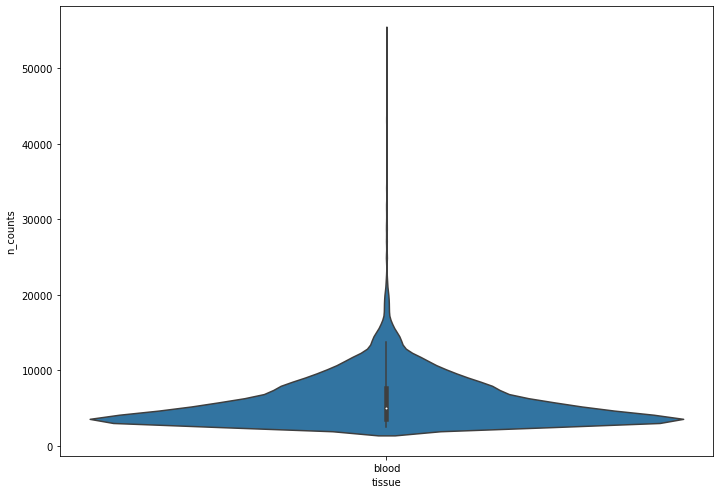

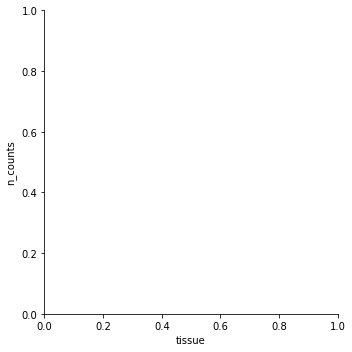

In [22]:
# df = adata
fig, ax = plt.subplots();
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.catplot(data=adata.obs,y='n_counts',x='tissue',kind='violin',ax=ax)

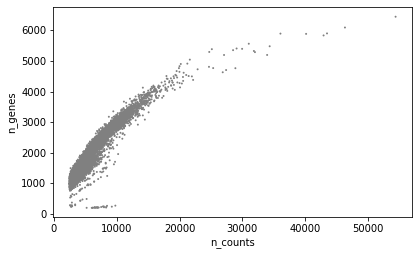

In [23]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Because we're doing first exploratory pass let's remove cells that have more than 5000 genes given that those have higher chances of being doublets

In [24]:
adata

AnnData object with n_obs × n_vars = 7814 × 22032 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

Following the standard pipeline, next we normalize, log, compute highly variable genes and scale

In [50]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata)

Next we compute PCA

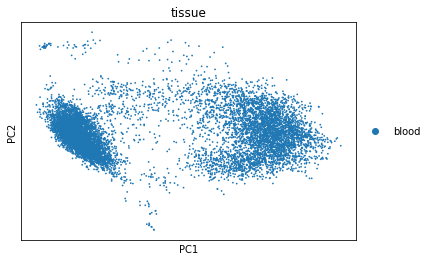

In [51]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='tissue')


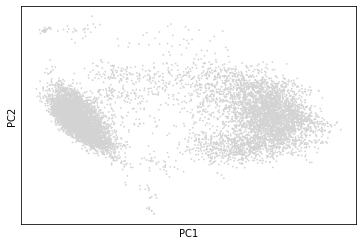

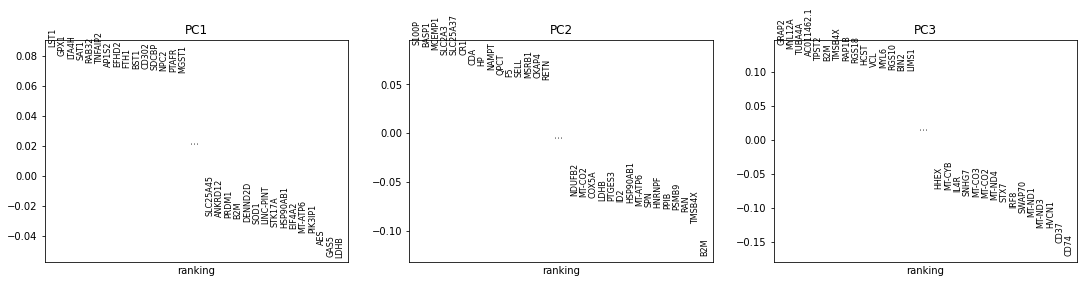

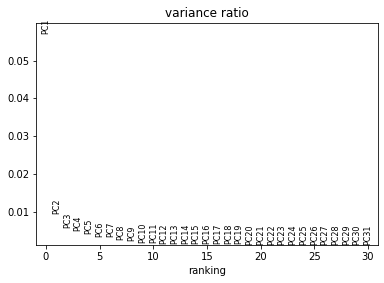

In [52]:
sc.pl.pca_overview(adata)


Now we're ready to start fishing out some structure in the data

In [53]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=30)


/home/angela/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/angela/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.7/site-packages/umap/uti

In [54]:
sc.tl.umap(adata)


In [32]:
set(adata.obs['10X_plate'])

{'1', '2'}

In [35]:
adata.obs.head()

,10X_plate,batch,tissue,method,sex,subjectid,n_genes,n_counts
AAACCCAAGTTGTCGT-1-0,2,0,blood,droplet,female,pilot,1379,4873.0
AAACGAAAGCCGTTAT-1-0,2,0,blood,droplet,female,pilot,1211,3293.0
AAAGGATAGTGTTGTC-1-0,2,0,blood,droplet,female,pilot,1458,4745.0
AAAGGGCAGGAACTAT-1-0,2,0,blood,droplet,female,pilot,1746,4816.0
AAAGGGCCAACCAACT-1-0,2,0,blood,droplet,female,pilot,3325,12989.0


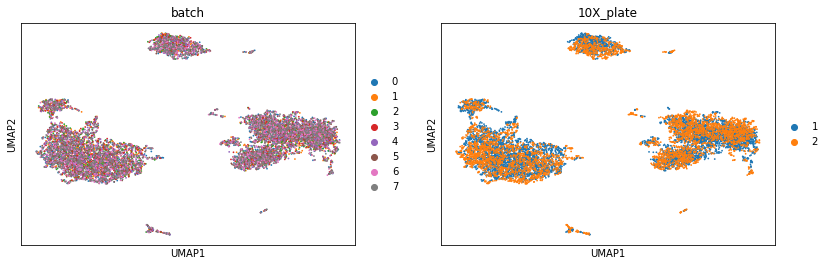

In [55]:
# sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['batch','10X_plate'])

In [65]:
adata.var_names[adata.var_names.str.startswith('MT')]

Index(['MTND1P23', 'MTND2P28', 'MTCO1P12', 'MTCO2P12', 'MTATP8P1', 'MTATP6P1',
       'MTCO3P12', 'MTOR', 'MTHFR', 'MT1XP1',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=173)

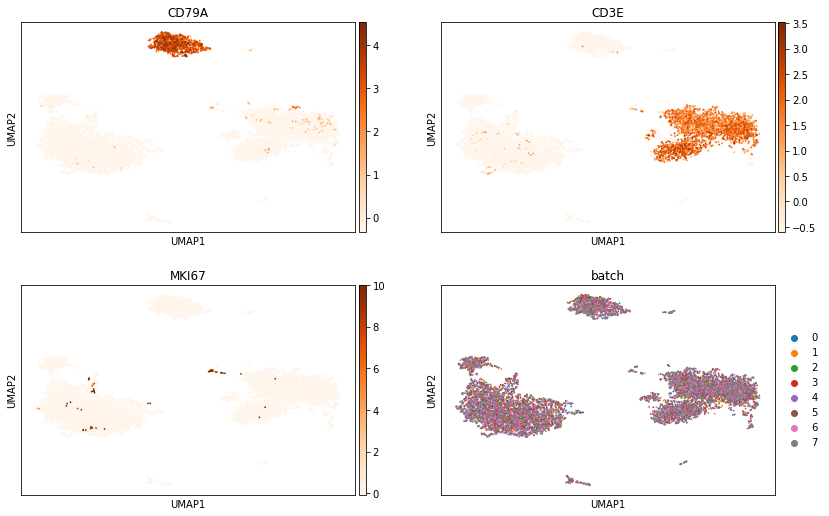

In [69]:
sc.pl.umap(adata,color=['CD79A','CD3E','MKI67','batch'],cmap='Oranges',ncols=2)

In [ ]:
set(adata.obs['tissue'])

In [ ]:
sc.pl.umap(adata, color=['tissue'],use_raw=False)

Let's take a look at one tissue as e.g. for batch effect...

In [ ]:
sc.pl.umap(adata[adata.obs['tissue']=='bladder'], color=['10X_plate'])

Looking good! Into clustering...

In [10]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color=['tissue','10X_plate','louvain'])

Using the wilcoxon rank test we can compute the marker genes for each of the 45 global clusters

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sapiens_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
sapiens_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes.csv')
sapiens_rank_genes.head(15)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes-scores.csv')
sapiens_rank_genes_scores.head(25)

Let's look at the overall cycling distribution just for curiosity

In [ ]:
# cell cycle distribution -- using Tirosh et al',' Science 2015
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


In [ ]:
adata

In [ ]:
sc.pl.umap(adata,color=['tissue','phase'])

Next we will look at the overall tissue compartments

In [ ]:
# add tissue compartments -- to be added
epithelial_markers = []
stromal_markers = []
immune_markers = []
endothelial_markera = []

# Load the annotated data

In [76]:
adata_pilot1 = sc.read_h5ad('../../../data-objs/pilot1/TSP1_objs_browser/TSP1_all.h5ad')
adata_pilot1

AnnData object with n_obs × n_vars = 68451 × 21301 
    obs: 'batch_id', 'compartment_prediction', 'leiden', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'pancreas_prediction', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'Compartment Prediction_colors', 'Pancreas Prediction_colors', 'Smoothed Compartment Prediction_colors', 'leiden', 'neighbors', 'smooth_comp2_colors', 'smooth_comp_colors'
    obsm: 'X_scvi', 'X_tsne', 'X_umap'

In [86]:
adata_pilot1.obs.head()

,batch_id,compartment_prediction,leiden,log1p_total_counts,manual_cell_ontology,manual_free_annotation,method,n_genes,pancreas_prediction,scANVI_organ_alternate_training_cell_ontology,scANVI_organ_alternate_training_free_annotation,scANVI_organ_cell_ontology,scANVI_organ_compartment_alternate_training_cell_ontology,scANVI_organ_compartment_alternate_training_free_annotation,scANVI_organ_compartment_cell_ontology,scANVI_organ_compartment_free_annotation,scANVI_organ_free_annotation,subtissue,tissue,tissue_method
index,,,,,,,,,,,,,,,,,,,,
AAACGAAAGCATCCCG-1-0,8,epithelial,63,6.467699,cell,unassigned,10x,500,not pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic ductal cell,endopancreas,pancreas,endopancreas_10x
AAAGGATTCTCGCCTA-1-0,8,epithelial,25,7.651596,cell,unassigned,10x,384,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AAAGGGCGTGGGCTCT-1-0,8,mixed,15,7.617760,pancreatic acinar cell,pancreatic acinar cell,10x,215,pancreas,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAAAGTCGAAGCCC-1-0,8,epithelial,48,6.666957,pancreatic acinar cell,pancreatic acinar cell,10x,343,pancreas,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic ductal cell,pancreatic ductal cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,endopancreas,pancreas,endopancreas_10x
AACAACCTCAACGAGG-1-0,8,endothelial,64,8.036250,endothelial cell,endothelial cell,10x,1590,not pancreas,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endothelial cell,endopancreas,pancreas,endopancreas_10x


In [ ]:
adata_pilot1.obs[adata_pilot1.obs['method']=='ss2'].to_csv('')

In [85]:
set(adata_pilot1.obs['method'])

{'10x', 'ss2'}

In [83]:
adata_pilot1_blood = adata_pilot1[adata_pilot1.obs['tissue']=='blood'].copy()
adata_pilot1_blood

AnnData object with n_obs × n_vars = 9560 × 21301 
    obs: 'batch_id', 'compartment_prediction', 'leiden', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'pancreas_prediction', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'Compartment Prediction_colors', 'Pancreas Prediction_colors', 'Smoothed Compartment Prediction_colors', 'leiden', 'neighbors', 'smooth_comp2_colors', 'smooth_comp_colors'
    obsm: 'X_scvi', 'X_tsne', 'X_umap'

In [84]:
len(set(adata_pilot1_blood.obs.index.values)&set(adata.obs.index.values))

0

# Split the tissues

In [ ]:
adata.obs.groupby(['tissue','10X_plate'])['subjectid'].agg({'ncells pilot':len})#.to_csv('/maca-bulk/sapiens/ncell_pilot.csv')




In [ ]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
print('tissue','total number of cells')
for t in list(set(adata.obs['tissue'])):
    tiss = adata[adata.obs['tissue']==t]
    print(t,len(tiss))
    tiss.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    

Analyse each tissue individually

In [ ]:
adata_all_tissues = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
for t in list(set(adata_all_tissues.obs['tissue'])):
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print('Now looking at ' +t+ '!!!')
    print(' ')
    adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    
    print('make sure data is consistent...')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    print('get global view of the tissue')
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    print('repeat the basic pre-processing')
    adata = adata[adata.obs['n_genes'] < 5000, :]
    adata = adata[adata.obs['n_counts'] > 500, :]
    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.scale(adata, max_value=10)
    
    print('PCA')
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_overview(adata)
    
    print('neighbors')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
    
    print('visualizations')
    sc.tl.umap(adata)
    sc.tl.tsne(adata)
    
    print('doing Louvain clustering for quick overview but likely to change this into Leiden')
    sc.tl.louvain(adata,resolution=.5)
    
    print('plot')
    sc.pl.tsne(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    sc.pl.umap(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    
    print('compute tissue rank genes')
    sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
    tiss_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    tiss_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes.csv')
    
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    tiss_rank_genes_score = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','pvals']})
    tiss_rank_genes_score.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes-score.csv')
    print(tiss_rank_genes.head(10))



    